In [ ]:
# import libraries
import numpy as np
import pandas as pd

In [ ]:
#create requirements.txt
!pip freeze > "/content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/flan-t5-large/requirements.txt"

In [ ]:
# connecting google drive to colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# reading train and test data
%cd /content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/flan-t5-large/

/content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/flan-t5-large


In [ ]:
# config.py
%%writefile config.py
from dataclasses import dataclass

@dataclass
class ModelConfig:
    # model configurations
    model_name: str = "google/flan-t5-large"
    num_labels: int = 3  # positive, negative, neutral

    # training configurations
    learning_rate: float = 5e-5
    batch_size: int = 4  # small batch size for Colab
    epochs: int = 8

    # LoRA configurations
    lora_r: int = 32
    lora_alpha: int = 64
    lora_dropout: float = 0.1

    # paths
    train_data_path: str = "data/new_train.csv"
    test_data_path: str = "data/new_test.csv"

    # Output
    output_dir: str = "sentiment_model"

Overwriting config.py


In [ ]:
# model.py
%%writefile src/model.py
import torch
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType

def create_model(config):
    model = AutoModelForSequenceClassification.from_pretrained(
        config.model_name,
        num_labels=config.num_labels,
        load_in_4bit = True
    )
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=config.lora_r,
        lora_alpha=config.lora_alpha,
        lora_dropout=config.lora_dropout,
        target_modules=['q', 'v']
    )
    peft_model = get_peft_model(model, lora_config)
    return peft_model

def count_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Trainable parameters: {trainable_params}")
    print(f"Total parameters: {total_params}")
    print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")


Overwriting src/model.py


In [ ]:
# data_loader.py
%%writefile src/data_loader.py

import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from config import ModelConfig
import pickle

class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

def tokenize_and_cache_data(datapath, tokenizer, max_length=128, cache_dir='cached_data_new'):
    os.makedirs(cache_dir, exist_ok=True)
    cache_filename = os.path.basename(datapath).replace('.csv', '_tokenized.pkl')
    cache_path = os.path.join(cache_dir, cache_filename)

    if os.path.exists(cache_path):
        print(f"Loading cached tokenized data from {cache_path}")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)

    df = pd.read_csv(datapath)
    prompt_prefix = "Classify the sentiment as positive, negative, or neutral: "
    texts = [prompt_prefix + str(text) for text in df['commentsReview'].tolist()]
    # texts = df['commentsReview'].tolist()
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    labels = [label_map[label.lower()] for label in df['sentiment']]

    encodings = tokenizer(texts, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encodings['input_ids']
    attention_masks = encodings['attention_mask']
    labels = torch.tensor(labels, dtype=torch.long)

    cached_data = (input_ids, attention_masks, labels)
    with open(cache_path, 'wb') as f:
        pickle.dump(cached_data, f)

    print(f"Tokenized data cached to {cache_path}")
    return cached_data

def create_dataloaders(config, tokenizer):
    train_input_ids, train_attention_masks, train_labels = tokenize_and_cache_data(config.train_data_path, tokenizer)
    test_input_ids, test_attention_masks, test_labels = tokenize_and_cache_data(config.test_data_path, tokenizer)

    train_dataset = SentimentDataset(train_input_ids, train_attention_masks, train_labels)
    test_dataset = SentimentDataset(test_input_ids, test_attention_masks, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    return train_loader, test_loader

Overwriting src/data_loader.py


In [ ]:
# train.py
%%writefile src/train.py

import torch
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from config import ModelConfig
from transformers import AutoTokenizer
from src.data_loader import create_dataloaders
from src.model import create_model, count_trainable_parameters
from src.evaluate import evaluate_model

def train_model(model, train_loader, test_loader, config, device,tokenizer):
    all_labels = torch.cat([batch['labels'] for batch in train_loader])
    class_weights = compute_class_weight('balanced', classes=np.unique(all_labels.cpu().numpy()), y=all_labels.cpu().numpy())
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

    best_val_loss = float('inf')
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    session_dir = os.path.join(config.output_dir, f"session_{timestamp}")
    os.makedirs(session_dir, exist_ok=True)

    train_losses = []
    val_losses = []

    for epoch in range(config.epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{config.epochs}, Training Loss: {avg_train_loss:.4f}")

        results = evaluate_model(model, test_loader, device)
        val_loss = results['loss']
        val_losses.append(val_loss)

        if val_loss < best_val_loss:

          # Save full model (overwrites previous best)
            best_val_loss = val_loss
            model.save_pretrained(session_dir)
            tokenizer.save_pretrained(session_dir)
            torch.save(model.state_dict(), os.path.join(session_dir, "best_model.pt"))
            # best_val_loss = val_loss
            # model_path = os.path.join(session_dir, f"best_model_epoch{epoch+1}.pt")
            # model.save_pretrained(session_dir)
            # torch.save(model.state_dict(), model_path)
            # tokenizer.save_pretrained(session_dir)
            print(f"Best model saved at epoch {epoch+1} with val loss {val_loss:.4f}")

    # Plot training vs validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(session_dir, 'loss_plot.png'))
    plt.close()

    return model

Overwriting src/train.py


In [ ]:
# evaluate.py
%%writefile src/evaluate.py
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds_tensor = torch.cat(all_preds)
    all_labels_tensor = torch.cat(all_labels)

    avg_loss = total_loss / len(data_loader)
    cm = confusion_matrix(all_labels_tensor.numpy(), all_preds_tensor.numpy())

    results = {
        "loss": avg_loss,
        "confusion_matrix": cm,
        "all_preds": [all_preds_tensor],
        "all_labels": [all_labels_tensor]
    }

    return results


Writing src/evaluate.py


In [ ]:
import os
import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from config import ModelConfig
from src.data_loader import create_dataloaders
from src.model import create_model, count_trainable_parameters
from src.evaluate import evaluate_model
from src.train import train_model
def main():
    config = ModelConfig()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    train_loader, test_loader = create_dataloaders(config, tokenizer)
    model = create_model(config)
    model.to(device)

    count_trainable_parameters(model)
    trained_model = train_model(model, train_loader, test_loader, config, device, tokenizer)

    results = evaluate_model(trained_model, test_loader, device)
    print("\n--- Final Evaluation Results ---")
    for key, value in results.items():
        if key != 'confusion_matrix':
            print(f"{key}: {value}")

    # Classification report
    y_true = torch.cat([batch['labels'] for batch in test_loader]).cpu().numpy()
    y_pred = torch.cat(results['all_preds']).cpu().numpy()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

    # Confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    os.makedirs(config.output_dir, exist_ok=True)
    plt.savefig(os.path.join(config.output_dir, 'confusion_matrix.png'))

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Tokenized data cached to cached_data_new/new_train_tokenized.pkl
Tokenized data cached to cached_data_new/new_test_tokenized.pkl


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 1376256
Total parameters: 62152067
Percentage of trainable parameters: 2.21%


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/8, Training Loss: 1.1148


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 27.48it/s]


Best model saved at epoch 1 with val loss 1.0384
Epoch 2/8, Training Loss: 1.0873


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 27.72it/s]


Best model saved at epoch 2 with val loss 1.0298
Epoch 3/8, Training Loss: 1.0700


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 27.62it/s]


Best model saved at epoch 3 with val loss 1.0048
Epoch 4/8, Training Loss: 1.0392


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 27.46it/s]


Best model saved at epoch 4 with val loss 0.9708
Epoch 5/8, Training Loss: 1.0179


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 27.57it/s]


Best model saved at epoch 5 with val loss 0.9549
Epoch 6/8, Training Loss: 0.9980


Evaluating: 100%|██████████| 259/259 [00:08<00:00, 29.77it/s]


Best model saved at epoch 6 with val loss 0.9332
Epoch 7/8, Training Loss: 0.9887


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 27.88it/s]


Epoch 8/8, Training Loss: 0.9785


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 28.47it/s]


Best model saved at epoch 8 with val loss 0.9299


Evaluating: 100%|██████████| 259/259 [00:10<00:00, 24.09it/s]



--- Final Evaluation Results ---
loss: 0.9299383852702771
all_preds: [tensor([0, 2, 2,  ..., 0, 2, 0])]
all_labels: [tensor([2, 2, 0,  ..., 2, 2, 2])]

Classification Report:
              precision    recall  f1-score   support

    negative       0.48      0.64      0.55       240
     neutral       0.56      0.04      0.08       246
    positive       0.66      0.84      0.74       549

    accuracy                           0.60      1035
   macro avg       0.57      0.51      0.45      1035
weighted avg       0.59      0.60      0.54      1035



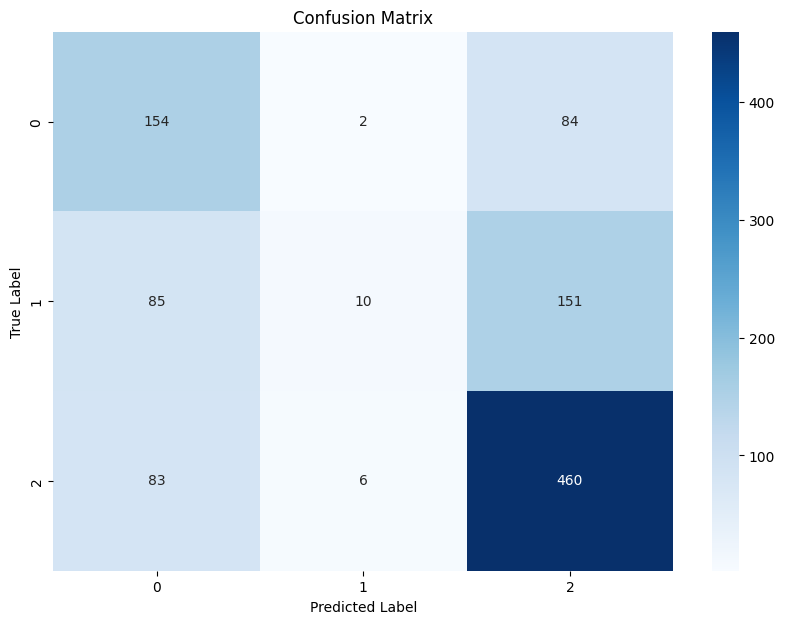

In [ ]:
if __name__ == '__main__':
    main()